# Image embedding feature extraction & Image comparison

### [ 기능적 요구사항 ] 
1. emdedding 기능
   1. CPU에서 동작 가능
   2. 이미지 사이즈 관계 없이 동작
   3. embedding vector의 차원 수 제한x but 유사도 검색 시 성능 저하 발생 x, 유사도 분류될 수 있을 수준 
2. 유사도 검색
   1. vector database 활용해 이미지 유사도 검색 가능해야 함
      - cosine similarity
   2. 같은 그룹의 이미지끼리 유사도 높고, 다른 그룹 이미지 유사도 낮아 -> 분류기의 기능 동작  
3. 시각화 위한 2D projection
   - 고차원의 vector dataset을 시각화하여 확인 위해 2D projection 지원

### [ 비기능적 요구사항 ]
1. 성능
   1. embedding
      1. 이미지 크기 별 임베딩 시간 분석 (1024x1024 기준 50msec 이하)
      2. 임베딩 벡터의 차원 수 제한 x but 유사도 검색 시 성능 저하 발생 x, 유사도 분류될 수 있을 수준   
         - dimension에 따른 유사도 검색 시간, 검색 정확도 분석
   2. 유사도
      1. dataset 10,000, 100,000 각각의 데이터셋 사이즈에 따른 유사도 검색 시간 분석
2. 보안
3. 가용성
   1. 임베딩, 유사도 검색 진행으로 인해 다른 API 요청이 blocking 되어선 x
4. 사용성
   1. 개발 언어 상관x but node.js, go 환경에서 호출이 가능해야 함
   2. Docker 환경에서 구동되어야 함

### [데이터 요구사항]
1. open source database 사용할 것

### [시스템 제약 사항]
1. 하드웨어 제약 : GPU 사용할 수 x

### [품질 요구사항]
1. 코드 품질
2. 테스트 전략
   1. 기능별 unit test case 확보 -> code coverage 60% 이상 확보
3. 유지보수성
   1. 유지 보수 가능한 코드 품질
   2. 의미 있는 변수명, 함수명
   3. 하나의 함수 길이 - 스크롤 없이 확인 가능
   4. 추상화된 클래스 상속받는 형태로 기능 구현 - 추후 확장성 고려

## 프로젝트 일정 및 일정 계획
1. 프로젝트 일정 : 2024년 6월 3일 ~ 2024년 7월 31일
2. 개발 단계 : 초기 한 달간 - embedding 알고리즘 구현 및 검증, 이후 한달간 - 서비스에 적용 및 테스트
3. 테스트 단계 : 개발 단계에 포함
4. 유지보수 단계 : 기존 팀원들이 이어서 진행

### 참조 
[ Embedding ](https://www.syncly.kr/blog/what-is-embedding-and-how-to-use)

[ Scatter Filter ](https://ko.docs.superb-ai.com/docs/scatter-filter)

[ Auto-Curate ](https://ko.docs.superb-ai.com/docs/auto-curate)

In [26]:
import numpy as np
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# 사전 학습된 EfficientNetB0 모델 로컬 파일 경로 지정
local_weights_path = '../efficientnetb0.h5'

base_model = EfficientNetB0(weights=None)
base_model.load_weights(local_weights_path)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('top_activation').output)

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    features = model.predict(img_data)
    return features.flatten()

# 예제 이미지의 feature 추출
features = extract_features('test_images/cat.jpg')
print(features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[-0.2736509  -0.26110074  0.5497928  ... -0.27174938 -0.27845186
 -0.27269047]


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# 예제 이미지들의 feature 벡터
image_features = [extract_features('test_images/face.jpg'), extract_features('test_images/face2.jpg'), extract_features('test_images/catdog.jpg')]

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(image_features)

print(similarity_matrix)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[[0.9999999  0.32229006 0.10640822]
 [0.32229006 1.0000013  0.02936372]
 [0.10640822 0.02936372 1.0000038 ]]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE를 사용한 2D 시각화
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(image_features)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
for i, txt in enumerate(['image1', 'image2', 'image3']):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]))
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Indices of most similar images: [[0 1 2]]
Distances to most similar images: [[    0.    41768.285 54554.266]]


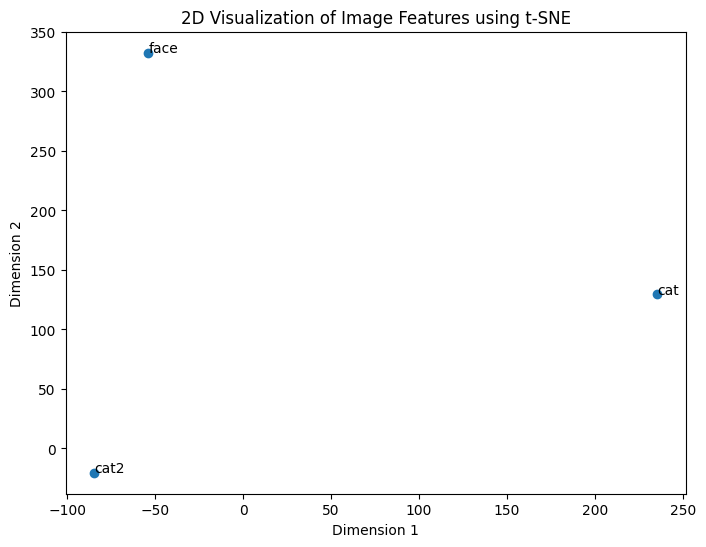

In [37]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import faiss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 사전 학습된 EfficientNetB0 모델 불러오기 (마지막 레이어를 제거하여 feature extractor로 사용)
base_model = EfficientNetB0(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('top_activation').output)

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    features = model.predict(img_data)
    return features.flatten()

# 예제 이미지들의 feature 벡터
image_features = np.array([
    extract_features('test_images/face.jpg'), 
    extract_features('test_images/face2.jpg'), 
    extract_features('test_images/catdog.jpg')
])

# FAISS 인덱스 생성 및 feature 벡터 추가
d = image_features.shape[1]  # feature 벡터의 차원 수
index = faiss.IndexFlatL2(d)  # L2 거리 기반의 인덱스
index.add(image_features)  # feature 벡터를 인덱스에 추가

# 검색할 쿼리 벡터 (예시로 첫 번째 이미지 사용)
query_vector = image_features[0].reshape(1, -1)

# 가장 유사한 이미지 검색
k = 3  # 검색할 이미지 개수
distances, indices = index.search(query_vector, k)

print("Indices of most similar images:", indices)
print("Distances to most similar images:", distances)

# t-SNE를 사용한 2D 시각화
tsne = TSNE(n_components=2, perplexity=2, random_state=0)  # perplexity를 2로 설정
tsne_results = tsne.fit_transform(image_features)

# 시각화를 위한 이미지 이름 리스트
image_names = ['cat', 'face', 'cat2']

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
for i, txt in enumerate(image_names):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Image Features using t-SNE')
plt.show()


## 6/4 

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models

# Load a pre-trained model
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model.eval()

# Define a transform to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()  # Remove batch dimension

# Example usage
features = extract_features('example_image.jpg')
print(features.shape)  # Should print (2048,)
